# Notebook Objectives

- In this notebook we will first download the phishing dataset, this will be saved to S3
- then we will perform some EDA to verfiy this is suitable dataset
- We will then clean the dataset and decide based on EDA which features to keep
- we will then save this cleaned dataset to s3. ready for model training

## Import Packages

In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import boto3

import math
from collections import Counter

## Read Data from S3

In [3]:
bucket = 'sagemaker-us-east-1-922945788052'
prefix = 'initial_dataset/PhiUSIIL_Phishing_URL_Dataset 2.csv'

# Construct the S3 URI
s3_uri = f's3://{bucket}/{prefix}'

# Use pandas directly
df = pd.read_csv(s3_uri)

## Explore Dataset

In [4]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

### Check Class Balance
- the target variable is the label, it is `0` for `phishing` and `1` for `legitmate`

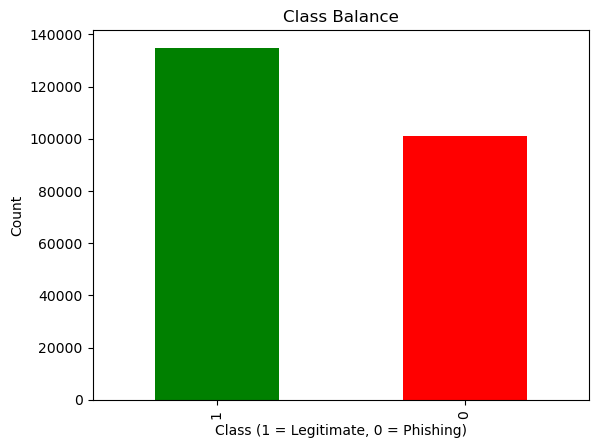

label
1    134850
0    100945
Name: count, dtype: int64
label
1    57.189508
0    42.810492
Name: proportion, dtype: float64


In [7]:
# Plot the class balance
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Balance')
plt.xlabel('Class (1 = Legitimate, 0 = Phishing)')
plt.ylabel('Count')
plt.show()

# Print label counts
print(df['label'].value_counts())

# Print class balance percentage
print(df['label'].value_counts(normalize=True) * 100)

- this shows the dataset is reasonably balanced, with a slight majority of legitimate URL's, the minority class is above 40% so no data imbalance treatment is needed

### Check for missing values

In [8]:
print(df.isnull().sum())

FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle

# Benchmark Model
- we will now train a simple lgistic regression model with this data
    - this will serve as the benchmark model for this project, will use just a single feature, `url_length`

- no missing values in this dataset

# Further EDA and Feature Engineering
- we will perform further EDA and feature engineering for the final model we will later train which should help improve its performance compared with benchmark model
### Explore Feature correlations with the target
- first we need only features that can be easy to compute at run time, ie easy to compute form just url.

In [100]:
simple_features = [
    'URL',
    'URLLength',
    'DomainLength',
    'IsDomainIP',
    'NoOfSubDomain',
    'NoOfLettersInURL',
    'LetterRatioInURL',
    'NoOfDegitsInURL',
    'DegitRatioInURL',
    'NoOfEqualsInURL',
    'NoOfQMarkInURL',
    'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL',
    'SpacialCharRatioInURL',
    'IsHTTPS',
    'CharContinuationRate'
]

In [106]:
# Create new dataset with these features
df_processed = df[simple_features]

In [ ]:
# we will create a new feature entropy

In [107]:
def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = -sum((count / length) * math.log2(count / length)
                    for count in counter.values() if count > 0)
    return entropy

In [108]:
# Create new entropy feature
df_processed['URLEntropy'] = df_processed['URL'].apply(calculate_entropy)

/tmp/ipykernel_208/2922718988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['URLEntropy'] = df_processed['URL'].apply(calculate_entropy)


In [113]:
df_processed.head(50)

,URL,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy,label
0,https://www.southbankmosaics.com,31,24,0,1,18,0.581,0,0.000,0,0,0,1,0.032,1,1.000000,3.929229,1
1,https://www.uni-mainz.de,23,16,0,1,9,0.391,0,0.000,0,0,0,2,0.087,1,0.666667,3.970176,1
2,https://www.voicefmradio.co.uk,29,22,0,2,15,0.517,0,0.000,0,0,0,2,0.069,1,0.866667,4.164735,1
3,https://www.sfnmjournal.com,26,19,0,1,13,0.500,0,0.000,0,0,0,1,0.038,1,1.000000,4.060262,1
4,https://www.rewildingargentina.org,33,26,0,1,20,0.606,0,0.000,0,0,0,1,0.030,1,1.000000,3.917626,1
5,https://www.globalreporting.org,30,23,0,1,17,0.567,0,0.000,0,0,0,1,0.033,1,1.000000,3.929214,1
6,https://www.saffronart.com,25,18,0,1,12,0.480,0,0.000,0,0,0,1,0.040,1,1.000000,3.796218,1
7,https://www.nerdscandy.com,25,18,0,1,12,0.480,0,0.000,0,0,0,1,0.040,1,1.000000,3.979098,1
8,https://www.hyderabadonline.in,29,22,0,1,16,0.552,0,0.000,0,0,0,1,0.034,1,1.000000,4.056565,1
9,https://www.aap.org,18,11,0,1,5,0.278,0,0.000,0,0,0,1,0.056,1,1.000000,3.471354,1


In [110]:
# add label back in
df_processed['label'] = df['label']  # assuming df still has the label column

/tmp/ipykernel_208/3475354163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['label'] = df['label']  # assuming df still has the label column


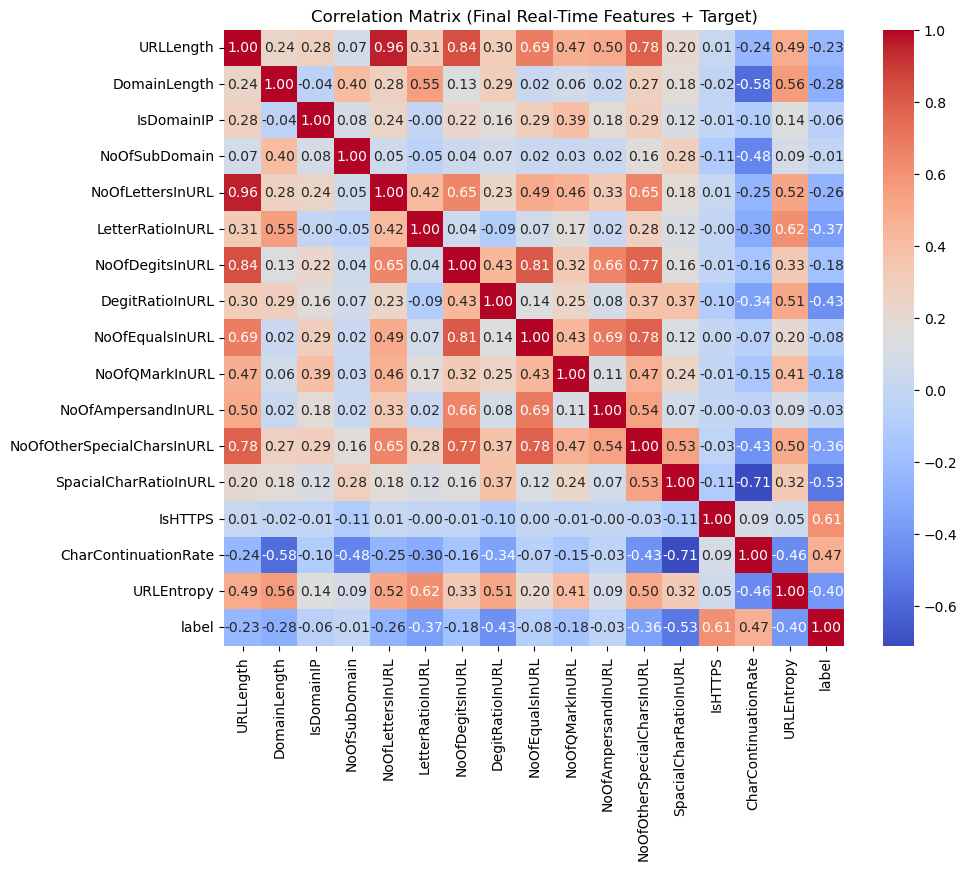

In [112]:
# Create correlation matrix for these features
corr_matrix_simple = df_processed.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_simple, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Final Real-Time Features + Target)')
plt.show()

- To avoid collinearity, we will drop features which have a correlation with each other of >0.8 these are also because count and ratio columns are avaialble so its duplication of data
- we will drop the following:
  -`NoOfLettersInURL`
  `NoOfDegitsInURL`
  `NoOfOtherSpecialCharsInURL`

  some are also highly correlated, but these will be kept due to domain knowledge length, digits characters etc are present in phishing links

In [ ]:
df_processed = df_processed.drop(columns=['NoOfLettersInURL', 'NoOfOtherSpecialCharsInURL', 'NoOfDegitsInURL'])

In [117]:
df_processed.head()

,URL,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,LetterRatioInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,SpacialCharRatioInURL,IsHTTPS,CharContinuationRate,URLEntropy,label
0,https://www.southbankmosaics.com,31,24,0,1,0.581,0.0,0,0,0,0.032,1,1.000000,3.929229,1
1,https://www.uni-mainz.de,23,16,0,1,0.391,0.0,0,0,0,0.087,1,0.666667,3.970176,1
2,https://www.voicefmradio.co.uk,29,22,0,2,0.517,0.0,0,0,0,0.069,1,0.866667,4.164735,1
3,https://www.sfnmjournal.com,26,19,0,1,0.500,0.0,0,0,0,0.038,1,1.000000,4.060262,1
4,https://www.rewildingargentina.org,33,26,0,1,0.606,0.0,0,0,0,0.030,1,1.000000,3.917626,1


# save final data to S3

In [119]:
df_processed.to_csv('../data/processed_phishing_data.csv', index=False)

In [120]:
s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-1-922945788052'
file_name = '../data/processed_phishing_data.csv'
s3_key = 'cleaned_dataset/processed_phishing_data.csv'

s3.upload_file(file_name, bucket, s3_key)
print(f"Uploaded {file_name} to s3://{bucket}/{s3_key}")

Uploaded ../data/processed_phishing_data.csv to s3://sagemaker-us-east-1-922945788052/cleaned_dataset/processed_phishing_data.csv
